Loading the trained model...


C:\Users\bened\AppData\Local\Temp\ipykernel_19100\4051574033.py:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(torch.load("best_bodym_model

✅ Model loaded successfully.


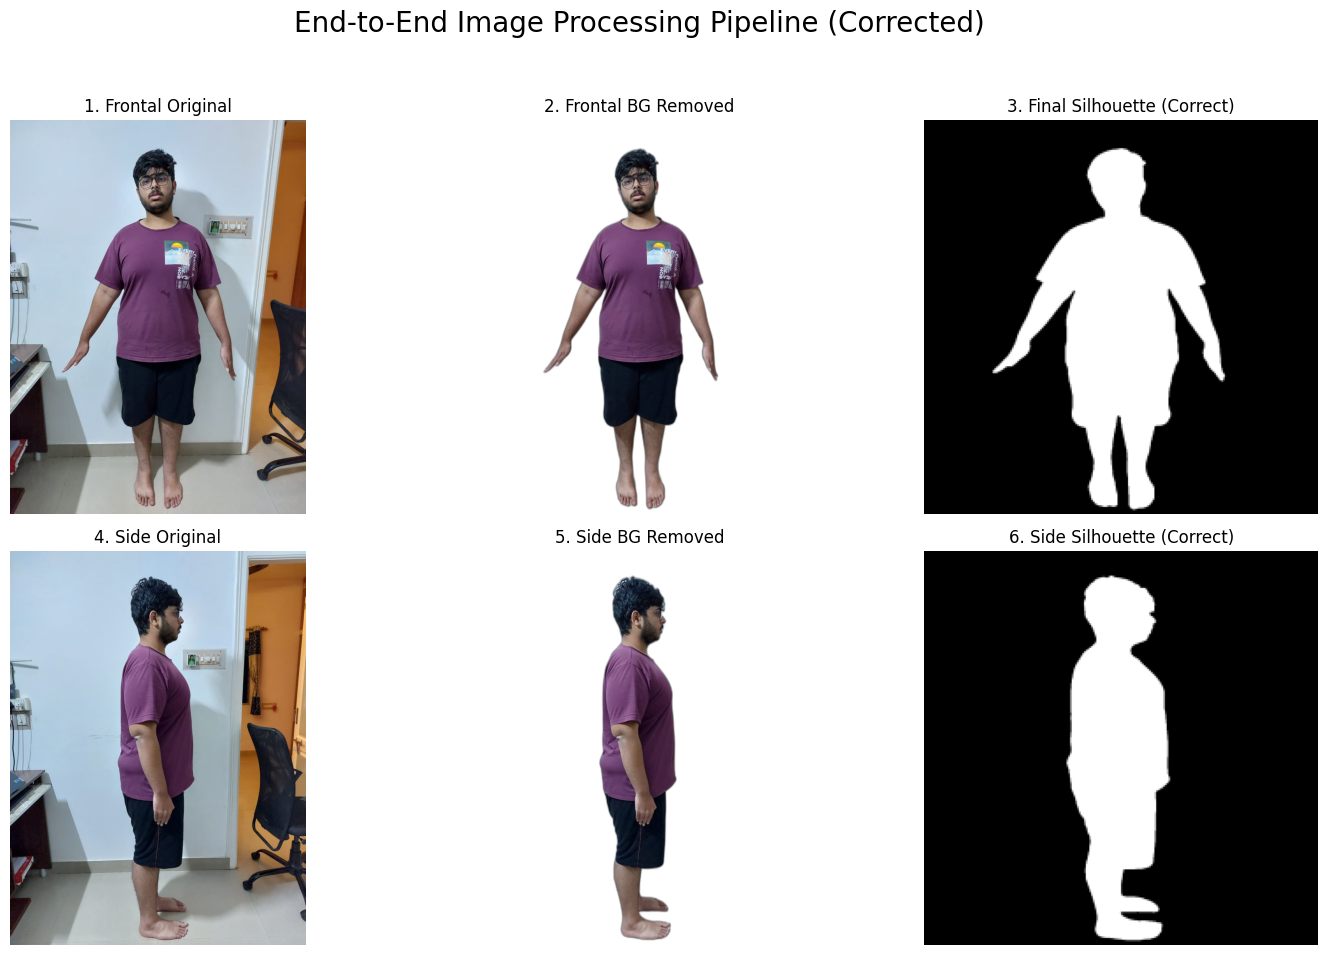


--- 📈 AI Biometric Analysis Complete ---
height_cm           : 173.14
weight_kg           : 108.24
ankle               : 26.57
arm-length          : 49.85
bicep               : 37.92
calf                : 42.79
chest               : 124.08
forearm             : 30.7
hip                 : 122.53
leg-length          : 78.22
shoulder-breadth    : 38.99
shoulder-to-crotch  : 68.69
thigh               : 64.45
waist               : 116.61
wrist               : 18.95
------------------------------------------


In [2]:
import torch
import torch.nn as nn
from torchvision import models
import cv2
import rembg
import numpy as np
from PIL import Image
import io
from torchvision import transforms
import matplotlib.pyplot as plt

# --- 1. The REAL Model Architecture Definition ---
class BodyM_MetricEstimator(nn.Module):
    def __init__(self, num_measurements):
        super(BodyM_MetricEstimator, self).__init__()
        self.frontal_branch = models.efficientnet_b4(weights=models.EfficientNet_B4_Weights.DEFAULT)
        self.side_branch = models.efficientnet_b4(weights=models.EfficientNet_B4_Weights.DEFAULT)
        num_features = self.frontal_branch.classifier[1].in_features
        self.frontal_branch.classifier = nn.Identity()
        self.side_branch.classifier = nn.Identity()
        self.regression_head = nn.Sequential(
            nn.Linear(num_features * 2, 1024), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(1024, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, num_measurements)
        )

    def forward(self, frontal_img, side_img):
        frontal_features = self.frontal_branch(frontal_img)
        side_features = self.side_branch(side_img)
        combined_features = torch.cat((frontal_features, side_features), dim=1)
        predictions = self.regression_head(combined_features)
        return predictions

# --- 2. The Silhouette Processing Function (Corrected) ---
def process_user_image_to_silhouette(input_image_path, output_size=(224, 224)):
    try:
        with open(input_image_path, 'rb') as f:
            input_image_data = f.read()
    except FileNotFoundError:
        return None, None
    try:
        output_rgba_data = rembg.remove(input_image_data)
        output_rgba = Image.open(io.BytesIO(output_rgba_data))
        output_np = np.array(output_rgba)
    except Exception:
        return None, None
    alpha_channel = output_np[:, :, 3]
    
    # This line creates the correct mask (white person, black background)
    _, silhouette = cv2.threshold(alpha_channel, 50, 255, cv2.THRESH_BINARY)
    
    # --- THIS IS THE FIX ---
    # The line below was incorrect and has been REMOVED.
    # silhouette = cv2.bitwise_not(binary_mask) 
    # --- END OF FIX ---

    silhouette_resized = cv2.resize(silhouette, output_size, interpolation=cv2.INTER_AREA)
    return silhouette_resized, output_rgba

# --- 3. The Visualization and Prediction Function ---
def visualize_and_predict(frontal_image_path, side_image_path, model, device):
    """Orchestrates the visualization and final prediction."""
    
    frontal_silhouette, frontal_bg_removed = process_user_image_to_silhouette(frontal_image_path)
    side_silhouette, side_bg_removed = process_user_image_to_silhouette(side_image_path)

    if frontal_silhouette is None or side_silhouette is None:
        print("Could not process one or both images. Please check file paths.")
        return

    frontal_original = Image.open(frontal_image_path)
    side_original = Image.open(side_image_path)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('End-to-End Image Processing Pipeline (Corrected)', fontsize=20)

    axes[0, 0].imshow(frontal_original); axes[0, 0].set_title("1. Frontal Original"); axes[0, 0].axis('off')
    axes[0, 1].imshow(frontal_bg_removed); axes[0, 1].set_title("2. Frontal BG Removed"); axes[0, 1].axis('off')
    axes[0, 2].imshow(frontal_silhouette, cmap='gray'); axes[0, 2].set_title("3. Final Silhouette (Correct)"); axes[0, 2].axis('off')

    axes[1, 0].imshow(side_original); axes[1, 0].set_title("4. Side Original"); axes[1, 0].axis('off')
    axes[1, 1].imshow(side_bg_removed); axes[1, 1].set_title("5. Side BG Removed"); axes[1, 1].axis('off')
    axes[1, 2].imshow(side_silhouette, cmap='gray'); axes[1, 2].set_title("6. Side Silhouette (Correct)"); axes[1, 2].axis('off')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    model.eval()
    image_transforms = transforms.Compose([
        transforms.ToPILImage(), transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(), transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    frontal_tensor = image_transforms(frontal_silhouette).unsqueeze(0).to(device)
    side_tensor = image_transforms(side_silhouette).unsqueeze(0).to(device)
    
    with torch.no_grad():
        predictions = model(frontal_tensor, side_tensor)
        
    predictions_np = predictions.squeeze(0).cpu().numpy()
    target_columns = [
        'height_cm', 'weight_kg', 'ankle', 'arm-length', 'bicep', 'calf', 'chest', 
        'forearm', 'hip', 'leg-length', 'shoulder-breadth', 'shoulder-to-crotch', 
        'thigh', 'waist', 'wrist'
    ]
    results = {name: round(float(value), 2) for name, value in zip(target_columns, predictions_np)}
    
    print("\n--- 📈 AI Biometric Analysis Complete ---")
    for measurement, value in results.items():
        print(f"{measurement:<20}: {value}")
    print("------------------------------------------")

# --- 4. Main Execution Block ---
if __name__ == '__main__':
    print("Loading the trained model...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    NUM_TARGETS = 15
    trained_model = BodyM_MetricEstimator(num_measurements=NUM_TARGETS)
    trained_model.load_state_dict(torch.load("best_bodym_model.pth"))
    trained_model.to(device)
    print("✅ Model loaded successfully.")

    user_frontal_photo = r"C:\Users\bened\Documents\Alyster Coding\PROJECTS\AI_GYM\imgs\alvin2.jpg"
    user_side_photo = r"C:\Users\bened\Documents\Alyster Coding\PROJECTS\AI_GYM\imgs\alvin1.jpg" # Using same for demo, change to a real side view photo
    
    visualize_and_predict(
        frontal_image_path=user_frontal_photo,
        side_image_path=user_side_photo,
        model=trained_model,
        device=device
    )